<a href="https://colab.research.google.com/github/Janhvi-S103/PixelSense-AI/blob/main/PixelSense_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Starting Smart Pixelator...
Enter pixelation intensity (0-100): 60
Using pixelation intensity: 60.0/100
Please upload your image(s) when prompted...


Saving istockphoto-956366756-612x612.jpg to istockphoto-956366756-612x612 (1).jpg

Processing istockphoto-956366756-612x612 (1).jpg...


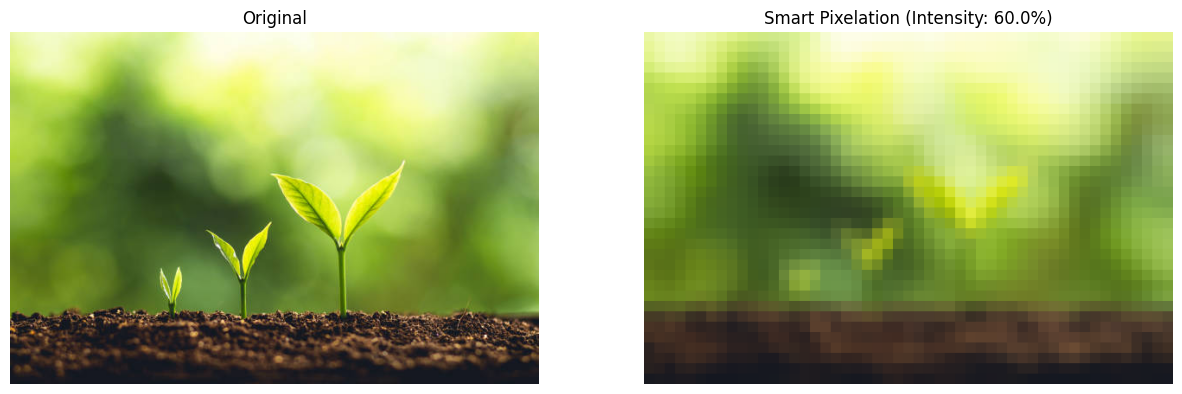

Saved as istockphoto-956366756-612x612 (1)_pixelated_60.0.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from google.colab import files
import io
import os
import matplotlib.pyplot as plt
from torchvision.models import resnet18

class AdaptivePixelationNetwork(nn.Module):
    def __init__(self):
        super(AdaptivePixelationNetwork, self).__init__()

        # Use pretrained ResNet18 as feature extractor
        resnet = resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-2])

        # Importance map generator
        self.importance_decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        importance_map = self.importance_decoder(features)
        importance_map = nn.functional.interpolate(
            importance_map,
            size=(x.shape[2], x.shape[3]),
            mode='bilinear',
            align_corners=False
        )
        return importance_map

class AdaptivePixelator:
    def __init__(self, base_pixel_size=8, intensity=50, device=None):
        self.base_pixel_size = base_pixel_size
        self.intensity = max(0, min(100, intensity))  # Clamp between 0-100
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Initialize model
        self.model = AdaptivePixelationNetwork().to(self.device)
        self.model.eval()

        # Image preprocessing
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def apply_adaptive_pixelation(self, image, importance_map):
        """Apply pixelation with varying intensity based on importance map and user-defined intensity"""
        img_np = np.array(image)
        importance_map = importance_map.squeeze().cpu().numpy()

        # Resize importance map to match image
        importance_map = Image.fromarray((importance_map * 255).astype(np.uint8))
        importance_map = importance_map.resize(image.size, Image.BILINEAR)
        importance_map = np.array(importance_map) / 255.0

        # Scale importance map based on user intensity
        intensity_factor = self.intensity / 50.0  # Convert 0-100 scale to scaling factor

        output = np.zeros_like(img_np)
        height, width = img_np.shape[:2]

        for y in range(0, height, self.base_pixel_size):
            for x in range(0, width, self.base_pixel_size):
                region_importance = importance_map[y:y+self.base_pixel_size,
                                                x:x+self.base_pixel_size].mean()

                # Adjust pixel size based on importance and user intensity
                pixel_size = int(self.base_pixel_size * (1 + (1 - region_importance) * 2 * intensity_factor))

                y_end = min(y + pixel_size, height)
                x_end = min(x + pixel_size, width)

                region = img_np[y:y_end, x:x_end]
                if region.size > 0:
                    color = region.mean(axis=(0, 1))
                    output[y:y_end, x:x_end] = color

        return Image.fromarray(output.astype(np.uint8))

    def pixelate_image(self, image_data):
        """Process image with adaptive pixelation"""
        try:
            original_image = Image.open(io.BytesIO(image_data)).convert('RGB')
            input_tensor = self.transform(original_image).unsqueeze(0).to(self.device)

            with torch.no_grad():
                importance_map = self.model(input_tensor)

            pixelated_image = self.apply_adaptive_pixelation(original_image, importance_map)

            return pixelated_image, original_image

        except Exception as e:
            print(f"Error processing image: {str(e)}")
            raise

def process_images(pixel_size=8, intensity=50):
    """Process uploaded images with the smart pixelator"""
    print(f"Using pixelation intensity: {intensity}/100")
    print("Please upload your image(s) when prompted...")
    uploaded = files.upload()

    if not uploaded:
        print("No files were uploaded.")
        return

    pixelator = AdaptivePixelator(base_pixel_size=pixel_size, intensity=intensity)

    for filename, data in uploaded.items():
        print(f"\nProcessing {filename}...")
        try:
            pixelated_image, original_image = pixelator.pixelate_image(data)

            # Display results
            plt.figure(figsize=(15, 5))

            plt.subplot(1, 2, 1)
            plt.imshow(original_image)
            plt.title("Original")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(pixelated_image)
            plt.title(f"Smart Pixelation (Intensity: {intensity}%)")
            plt.axis('off')

            plt.show()

            output_filename = f"{os.path.splitext(filename)[0]}_pixelated_{intensity}.png"
            pixelated_image.save(output_filename)
            print(f"Saved as {output_filename}")
            files.download(output_filename)

        except Exception as e:
            print(f"Error processing {filename}: {e}")
            continue

if __name__ == "__main__":
    print("Starting Smart Pixelator...")
    # Get user input for intensity
    while True:
        try:
            intensity = float(input("Enter pixelation intensity (0-100): "))
            if 0 <= intensity <= 100:
                break
            print("Please enter a value between 0 and 100.")
        except ValueError:
            print("Please enter a valid number.")

    process_images(pixel_size=12, intensity=intensity)